In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from core.normalize import *
from core.outliers import *
from core.test_model import test_model_from_scratch, optimize_normalization, test_model
from core.kfold_cv import *
from core.annotate import categorize_cogdx


print('scanpy: ', sc.__version__)
print('pandas: ', pd.__version__)


ROSMAP_PATH = 'ROSMAP_clinical.csv'
CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ROSMAP_data = pd.read_csv(ROSMAP_PATH)
ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)

#ROSMAP_data = ROSMAP_data.convert_dtypes()
#ct_counts_metadata.obs = ct_counts_metadata.obs.convert_dtypes()

scanpy:  1.10.1
pandas:  2.2.2


In [2]:
categorize_cogdx(ct_counts_metadata, {1: 'H', 2: 'M', 3: 'M', 4: 'AD', 5: 'AD', 6: 'O'})

In [3]:
# Obtain the raw baseline performance

from sklearn.tree import DecisionTreeClassifier

AD_filter = (ct_counts_metadata.obs['cogdx_class'] == 'AD') | (ct_counts_metadata.obs['cogdx_class'] == 'H')
y = ct_counts_metadata.obs['cogdx_class'][AD_filter].cat.codes

baseline_df = test_model(ct_counts_metadata[AD_filter], model=DecisionTreeClassifier(random_state=42), norm_layer=None, y=y).assign(_h='DT (Baseline)')

In [4]:
#print(np.isnan(ct_counts_metadata.obs['pmi'].to_numpy()[27*6 - 3]))
ct_counts_metadata = ct_counts_metadata[~np.isnan(ct_counts_metadata.obs['pmi'].to_numpy())]
#print(len(ct_counts_metadata.obs['pmi'].tolist()))
#ct_counts_metadata.obs['pmi_type'] = ct_counts_metadata.obs['pmi'].apply(type)
#display(ct_counts_metadata.obs['pmi_type'].value_counts())
sc.pp.regress_out(ct_counts_metadata, keys=['pmi'])
calculate_ct_per_median(ct_counts_metadata, 'Exc RELN CHD7', column_name='RELN_metric')
ct_counts_metadata = remove_outliers(ct_counts_metadata, 'RELN_metric', np.percentile(ct_counts_metadata.obs['RELN_metric'], 97))
ct_counts_metadata = ct_counts_metadata[:, ct_counts_metadata.var_names != 'Exc RELN CHD7']


/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts


In [5]:
# Hyper parameter classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, RidgeClassifier

AD_filter = (ct_counts_metadata.obs['cogdx_class'] == 'AD') | (ct_counts_metadata.obs['cogdx_class'] == 'H')
y = ct_counts_metadata.obs['cogdx_class'][AD_filter].cat.codes
X = pd.DataFrame(ct_counts_metadata.X, columns=ct_counts_metadata.var_names, index=ct_counts_metadata.obs_names)[AD_filter]

Starting iteration h=RandomForestClassifier(random_state=42).......... Done!
Starting iteration h=Lasso().......... Done!
Starting iteration h=RidgeClassifier().......... Done!


/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true


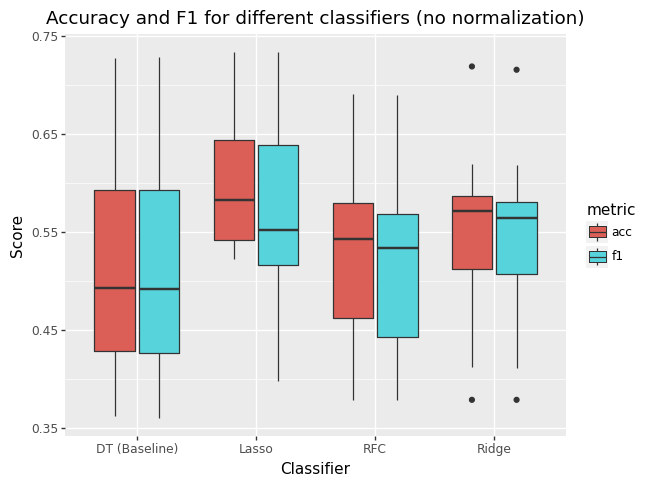

In [6]:
H = [RandomForestClassifier(random_state=42),
     Lasso(),
     RidgeClassifier()]
H_mask = ['RFC', 'Lasso', 'Ridge']

def cv_classifiers(X_train, y_train, X_valid, y_valid, h):
    m = h.fit(X_train, y_train)
    pred: np.ndarray = m.predict(X_valid).round(0)

    return {'acc': balanced_accuracy_score(y_valid, pred), 
            'f1': f1_score(y_valid, pred, average='macro')}
    

results = pd.concat([optimize_hyperparam(X, y, 10, H, cv_classifiers, H_mask=H_mask), baseline_df], axis=0)

plot_optimization_box(results, 'Accuracy and F1 for different classifiers (no normalization)')

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/normalize.py:15: ImplicitModificationWarning: Setting element `.layers['l1']` of view, initializing view as actual.
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:377: RuntimeWarning: invalid value encountered in log1p
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:377: RuntimeWarning: invalid value encountered in log1p
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:377: RuntimeWarning: invalid value encountered in log1p
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:377: RuntimeWarning: invalid value encountered in log

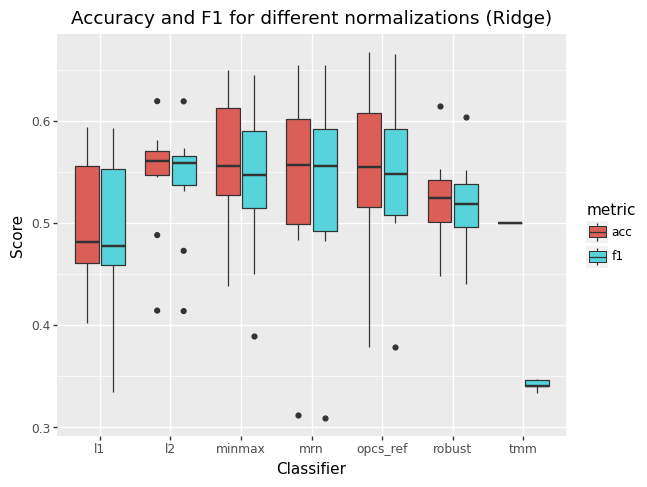

In [7]:
optimized_norms = optimize_normalization(ct_counts_metadata[AD_filter], ct_counts_metadata.obs['cogdx_class'][AD_filter], RidgeClassifier())
plot_optimization_box(optimized_norms, 'Accuracy and F1 for different normalizations (Ridge)')

In [8]:
optimized_norms = optimize_normalization(ct_counts_metadata[AD_filter], ct_counts_metadata.obs['cogdx_class'][AD_filter], Lasso())
plot_optimization_box(optimized_norms, 'Accuracy and F1 for different normalizations (Lasso)')

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/normalize.py:15: ImplicitModificationWarning: Setting element `.layers['l1']` of view, initializing view as actual.
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:377: RuntimeWarning: invalid value encountered in log1p


ValueError: Classification metrics can't handle a mix of binary and continuous targets